In [1]:
using Pkg

In [2]:
Pkg.activate(dirname(pwd()))

  Activating project at `~/Documents/GitHub/ComputationalHeatTransfer.jl`


In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using JLD2
using Plots
gr()  


┌ Info: Precompiling ComputationalHeatTransfer [5fc296c8-2eb5-40dc-a46d-98a68011a900]
└ @ Base loading.jl:1662


Plots.GRBackend()

## Control Console

In [106]:
Rn = 3e-6
δfilm = 2e-5
ad_fac = 1.3
plate_d = 1.5e-3;
Eratio = 0.3

0.3

In [107]:
fluid_type = "Butane"
Tref = 291.2

291.2

In [108]:
power = 10 #watts
hc = 3000.0
Tc = Tref;

# Properies

### Solid Physical parameters

In [109]:
ρₛ = 2730; # density
cₛ  = 8.93e02; # specific heat
kₛ  = 1.93e02; # heat conductivity
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

### Fluid Physical parameters

In [110]:
p_fluid = SaturationFluidProperty(fluid_type,Tref);

# Plate Conduction

### Geometry parameters

In [111]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [112]:
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits
Δx,Δt_max = setstepsizes(params.α,gridPe=8.0,fourier=0.3)

(0.0006333345639056725, 0.001520002953373614)

## Set up the OHP

In [113]:
OHPtype = "ASETS-II OHP 2 SMALL HEATER"

"ASETS-II OHP 2 SMALL HEATER"

In [114]:
eparams,cparams = OHPConfiguration(OHPtype,power,Tc,hc,Δx);

In [115]:
x, y, xf, yf = construct_ohp_curve("ASETS",Δx)
ohp = BasicBody(x,y)
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{4877, RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

In [116]:
# plot(ohpgeom.body,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

### create HeatConduction system

In [117]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt_max,qline=ohpgeom,qflux=eparams,qmodel=cparams)

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


# OHP inner part

### Tube geometries

In [118]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = 133.83*1e-3 # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

N=numpts(ohp);

In [119]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,gravity,closedornot,N,fluid_type);

### Liquid

In [120]:
Nu = 3.60
Hₗ = p_fluid.kₗ/tube_d * Nu # Nusselt number 4.36

387.3775707791756

In [121]:
X0,realratio = randomXp(tube)
dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r);

In [122]:
realratio

0.4608593802801127

In [123]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tref,L);

In [124]:
liquids=Liquid(Hₗ,p_fluid.ρₗ,p_fluid.Cpₗ,p_fluid.αₗ,p_fluid.μₗ,p_fluid.σ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [125]:
Hᵥ = p_fluid.kᵥ/tube_d * Nu # Nusselt number 4.36
# Hᵥ = 0.0 # Nusselt number 4.36

57.21608452726913

In [126]:
P = 0*zeros(length(X0)) .+ TtoP(Tref);
# δ = 0*zeros(length(X0)) .+ 1.0e-5;
δfilm_deposit = δfilm;
δstart = 0*zeros(length(X0)) .+ δfilm ;
δend = 0*zeros(length(X0)) .+ δfilm ;

Lvaporplug = XptoLvaporplug(X0,L,tube.closedornot)
Lfilm_start = 0.01 .* Lvaporplug
Lfilm_end = 0.01 .* Lvaporplug
# Eratio = 0.75
# δratio = 0*zeros(length(X0)) .+ 0.99;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δmin = 2e-6
vapors=Vapor(Hᵥ,p_fluid.kₗ,δmin,Eratio,P,δfilm_deposit,δstart,δend,Lfilm_start,Lfilm_end);

### Wall

### nucleate boiling sites

In [127]:
ΔTthres = RntoΔT(Rn,Tref,fluid_type,tube_d)

1.40436165473792

In [128]:
nucleatenum = 1000
Xstations = sort(rand(nucleatenum) .* L);

In [129]:
boil_type = "wall T"
boil_interval = 0.01
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tref);
θwallarray .= Tref

wall = Wall(boil_type,boil_interval,Rn,Xstations,Xwallarray,θwallarray);

In [130]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [131]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [132]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac

u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
# u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [133]:
function immersedboundary_condition(u,t,integrator)
    true
end

immersedboundary_condition (generic function with 1 method)

In [134]:
function immersedboundary_affect!(integrator)
    integrator.p.wall.θarray = deepcopy(temperature_linesource(Main.integrator_plate))
end

immersedboundary_affect! (generic function with 1 method)

In [135]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
cb_vapormerging =  DiscreteCallback(merging_condition,merging_affect!)
cb_liquidmerging = DiscreteCallback(vaporMergingCondition,vaporMergingAffect!)
cb_fixdx =  DiscreteCallback(fixdx_condition,fixdx_affect!)
cbst = CallbackSet(cb_fixdx,cb_boiling,cb_vapormerging,cb_liquidmerging);

# combine inner tube and plate together

In [150]:
tspan = (0.0, 20.0);
num_data = 200
dt_record = tspan[2] /num_data;

tstep = 1e-3

0.001

In [137]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
temperature(integrator_plate) .= Tref;

In [138]:
p = sys0
u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_on=false, dt=tstep, callback=cbst);
currentsys = getcurrentsys(integrator_tube.u,integrator_tube.p);

## Resume

In [139]:
# integrator_plate = integrator_plate_temp;

In [140]:
# integrator_tube = tube_hist[end];

## Start

In [141]:
boil_hist=[]
plate_T_hist = []
tube_hist_u  = []
tube_hist_t = []
tube_hist_θwall = []

Any[]

In [142]:
using Distributed
using ProgressMeter

In [153]:
prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t,integrator_plate.t+tspan[2]-tspan[1]), currentsys)
integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep,save_on=false);

@showprogress for t in tspan[1]:tstep:tspan[2]
# @time for t in tspan[1]:tstep:tspan[1]
     step!(integrator_tube,tstep,true);

        currentsys = deepcopy(getcurrentsys(integrator_tube.u,integrator_tube.p))
        currentsys.wall.θarray = deepcopy(temperature_linesource(integrator_plate))
        integrator_tube.p = deepcopy(currentsys)
        qtmp = deepcopy(sys_to_heatflux(currentsys))
       set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)

    integrator_plate.t += tstep
    
    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_T_hist,deepcopy(temperature(integrator_plate))); 
        push!(tube_hist_θwall,deepcopy(integrator_tube.p.wall.θarray))
        push!(tube_hist_u,deepcopy(integrator_tube.u));
        push!(tube_hist_t,deepcopy(integrator_tube.t));
        integrator_plate_temp = deepcopy(integrator_plate)
#         println(sys.qline[1].q[1:5])
    end
    
end
# integrator_plate.t

Progress:   5%|██▏                                      |  ETA: 0:09:57

LoadError: InterruptException:

In [154]:
boil_hist

65-element Vector{Any}:
 [492.0, 0.11000000000000003]
 [510.0, 0.12000000000000004]
 [540.0, 0.12000000000000004]
 [540.0, 0.13000000000000003]
 [540.0, 0.14000000000000004]
 [540.0, 0.15000000000000005]
 [540.0, 0.15999630676654944]
 [632.0, 0.3300000000000002]
 [377.0, 0.3500000000000002]
 [409.0, 0.3500000000000002]
 [632.0, 0.3600000000000002]
 [409.0, 0.3700000000000002]
 [377.0, 0.3800000000000002]
 ⋮
 [436.0, 1.0399999999999998]
 [539.0, 1.0399999999999998]
 [539.0, 1.1499999999999975]
 [539.0, 1.1599999999999973]
 [539.0, 1.169999999999997]
 [539.0, 1.1799999999999968]
 [539.0, 1.1899928961154091]
 [540.0, 1.1999999999999964]
 [541.0, 1.2099999999999962]
 [541.0, 1.219999999999996]
 [493.0, 1.9199999999999735]
 [493.0, 2.0199999999999627]

In [155]:
sysfinal = []
for i = 1:length(tube_hist_u)
    sysfinaltemp = deepcopy(getcurrentsys(tube_hist_u[i],integrator_tube.p))
    sysfinaltemp.wall.θarray = tube_hist_θwall[i]
    push!(sysfinal, sysfinaltemp)
end

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif")
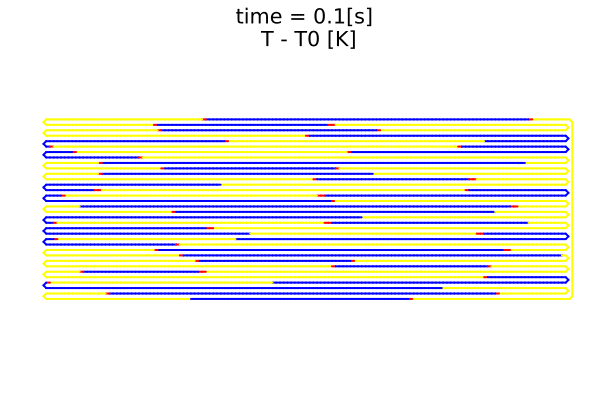

In [156]:
@gif for i=1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = getHtmp_marker.(Htmp,[Hₗ],[Hᵥ])
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),line_z=Htmp_marker,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist_t[i], digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

## Store data

In [87]:
using JLD2

In [88]:
boil_station_hist = [elem[1] for elem in boil_hist]
boil_t_hist = [elem[2] for elem in boil_hist]
boil_data = Array(reshape([boil_station_hist;boil_t_hist], length(boil_t_hist),2));

In [89]:
save(dirname(dirname(dirname(pwd())))*"/OHPnume/OHP4_40W_E030_1_DT1_large.jld2",
    "tube_hist_θwall", tube_hist_θwall,"tube_hist_u", tube_hist_u,"tube_hist_t", tube_hist_t,
    "integrator_tube",integrator_tube,"plate_T_hist", plate_T_hist,
    "integrator_plate", integrator_plate, "boil_data", boil_data,"ohp",ohp)